In [1]:
import pandas as pd
import numpy as np
import json as js
import os
import time
import pathlib
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

## Code to read original json text (Please Skip)

In [2]:
# List of columnes to be retrieved from json
columns_list = ['text', 'favorite_count', 'retweet_count','user.followers_count', 'user.friends_count', 'user.verified','user.created_at', 'created_at']

In [3]:
def readJson(file):
    # tweet contain non-rumor
    if 'non-rumours' in file and 'source-tweet'in file:
        label = 0
    # tweet contain rumor
    elif 'rumours' in file and 'source-tweet'in file:
        label = 1
    else:
        label = -1
    with open (file) as f:
        try:
            d = js.load(f)
            df = pd.json_normalize(d)
            df['label'] = label
            df_final = df[columns_list]
            df_final.insert(0,'label',label)
        except:
            empty_df = pd.DataFrame()
            return empty_df
    return df_final

In [4]:
####Define Path of Data Folder#####
root_path = str(pathlib.Path().absolute().parent)
data_path='/Data/pheme-rnr-dataset/'
folder_list = ['ferguson', 'charliehebdo', 'germanwings-crash', 'ottawashooting', 'sydneysiege']

In [5]:
####Scan thru rumor folders####
first = True
for folder in folder_list:
    for subdirs, dirs, files in os.walk(root_path+data_path+folder):
        for file in files:
            file_dir = str(os.path.join(subdirs, file))
            df = readJson(file_dir)
            if(df.empty != True ):
                if first == True:
                    if  df.label[0] != -1:
                        tweets = df
                        first = False
                else:
                    if df.label[0] != -1:
                        tweets = tweets.append(df, ignore_index=True)

In [7]:
tweets.to_csv('raw_train.csv')

## Extract Train Tweets Data set (Please skip) ##

In [51]:
data_path = '/Data/'
date_list = ['2020-03-16', '2020-03-17','2020-03-18','2020-03-19','2020-03-20','2020-03-21','2020-03-22']
file= ' Coronavirus Tweets.csv'
test_df = pd.DataFrame()
for date in date_list:
    df = pd.read_csv(root_path+data_path+date+file)
    df = df[df.country_code=='US'].sample(300, random_state=123)
    test_df = test_df.append(df)

In [52]:
# Adjust columne name in train data
test_data = pd.DataFrame()
test_data['label'] = ''
test_data['text'] = test_df['text']
test_data['favorite_count'] = test_df['favourites_count']
test_data['retweet_count'] = test_df['retweet_count']
test_data['user.followers_count'] = test_df['followers_count']
test_data['user.friends_count'] = test_df['friends_count']
test_data['user.verified'] = test_df['verified']
test_data['user.created_at'] = test_df['account_created_at']
test_data['created_at'] = test_df['created_at']

In [74]:
test_data.to_csv('raw_test.csv')

# Processing Code Start Here 

In [2]:
tweets = pd.read_csv('raw_train.csv') # read raw training data
test_data = pd.read_csv('raw_test.csv') # read raw test data

In [3]:
tweets.shape

(5802, 10)

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/liaowenhao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/liaowenhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liaowenhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liaowenhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
## remove url link from text
def remove_url(text):
    n_text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    return n_text

## count url links
def cnt_url(text):
    return len(re.findall(r'http\S+', text, flags=re.MULTILINE))

In [6]:
def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos= nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    # Adjective tags -'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags -'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags -'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags -'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl= WordNetLemmatizer()
    for word in words:
        pos= find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

In [7]:
def remove_stopwords(text, lang='english'):
    words = nltk.word_tokenize(text)
    lang_stopwords = stopwords.words(lang)
    stopwords_removed = [w for w in words if w.lower() not in lang_stopwords]
    return " ".join(stopwords_removed)

In [8]:
def remove_unwanted(text):
    lower_text = text.lower()
    
    remove_unwanted_charectors = re.sub(r'[^a-zA-Z0-9_#@&\s]', ' ', lower_text) # Remove unwated charectors like punctuations andnon ascii 
    remove_unwanted_charectors = re.sub(r'&[\w]+', ' ', remove_unwanted_charectors) # Remove &amp, *&words etc
    
    removed_extra_space = re.sub(r'\s+',' ', remove_unwanted_charectors) # Remove extra white_spaces
    
    extract_hash = re.findall(r'#[\w]+', removed_extra_space) # Extract #hashTags
    extract_has_joined = " ".join(extract_hash)
    removed_hash_text = re.sub(r'#[\w]+', '', removed_extra_space) # Remove #hastags
    
    remove_atrate = re.findall(r'@[\w]+', removed_hash_text) # Extract @Users
    count = len(remove_atrate)
    removed_atrate = re.sub(r'@[\w]+', '', removed_hash_text) # Remove @Users
    
    return removed_atrate
    

In [9]:
# Compute text length and avg word length
def text_len(text):
    text = remove_url(text)
    text = remove_unwanted(text)
    words = nltk.word_tokenize(text)
    # Compute total length
    return len(words)

def avg_word_len(text):
    text = remove_url(text)
    text = remove_unwanted(text)
    words = nltk.word_tokenize(text)
    # avg word length
    return round(np.average([len(word) for word in words])) 

In [10]:
def cnt_url(text):
    return len(re.findall(r'http\S+', text, flags=re.MULTILINE))

In [11]:
# Count punctuation
def cnt_punctuation(text):
    return len(re.findall(r'[!.?\-",]', text))

In [12]:
def compute_age(time1, time2):
    delta = pd.to_datetime(time1) - pd.to_datetime(time2)
    return round(delta.days/365, 2)

In [13]:
# Process tweets
def process_tweet(tweets):
    new_tweets = tweets
    new_tweets.insert(2,'original', tweets['text'])
    new_tweets['txt_len'] = tweets['text'].apply(text_len) 
    new_tweets['avg_wrd_length'] = tweets['text'].apply(avg_word_len)
    new_tweets['url_cnt'] = tweets['text'].apply(cnt_url)
    new_tweets['text'] = tweets['text'].apply(remove_url)
    new_tweets['puncutaion_cnt'] = tweets['text'].apply(cnt_punctuation)
    new_tweets['text'] = new_tweets['text'].apply(remove_unwanted)
    new_tweets['text'] = new_tweets['text'].apply(remove_stopwords)
    new_tweets['text'] = new_tweets['text'].apply(words_lemmatizer)
    new_tweets['tweet_age'] = new_tweets.apply(lambda x: compute_age(x['created_at'], x['user.created_at']), axis=1)
    
    return new_tweets

In [14]:
df = process_tweet(tweets)
df = df[df.columns[1:]]

In [15]:
test = process_tweet(test_data)

/Users/liaowenhao/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


In [16]:
# ouput train processed data
df.to_csv('train.csv', index=False)

In [17]:
# ouput test processed data
test.to_csv('test.csv', index=False)

### Data Exploration ###

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [19]:
tweets = pd.read_csv('EDA_analysis.csv')

In [20]:
# data for each event
ferguson_df = tweets[tweets.event == 'ferguson']
charliehebdo_df = tweets[tweets.event == 'charliehebdo']
germanwings_crash_df = tweets[tweets.event == 'germanwings-crash']
ottawashooting_df = tweets[tweets.event == 'ottawashooting']
sydneysiege_df = tweets[tweets.event == 'sydneysiege']
# dictionary for event data
data = { 
    'ferguson':ferguson_df,
    'charliehebdo':charliehebdo_df,
    'germanwings_crash':germanwings_crash_df,
    'ottawashooting':ottawashooting_df,
    'sydneysiege':sydneysiege_df,
}

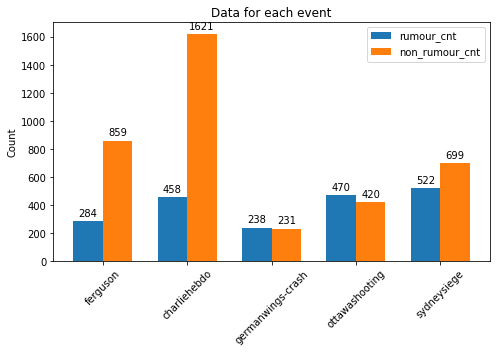

In [22]:
# Distribution of each event
labels = ['ferguson', 'charliehebdo', 'germanwings-crash', 'ottawashooting', 'sydneysiege']
rumour_cnt = [len(data[event][data[event].label==1].label) for event in data.keys()]
non_rumour_cnt = [len(data[event][data[event].label==0].label) for event in data.keys()]

# Plot in pyplot
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize = (7,5))
rects1 = ax.bar(x - width/2, rumour_cnt, width, label='rumour_cnt')
rects2 = ax.bar(x + width/2, non_rumour_cnt, width, label='non_rumour_cnt')

ax.set_ylabel('Count')
ax.set_title('Data for each event')
ax.set_xticks(x)
ax.set_xticklabels(labels)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [23]:
final_df = df

Text(0.5, 0, 'non_rumour')

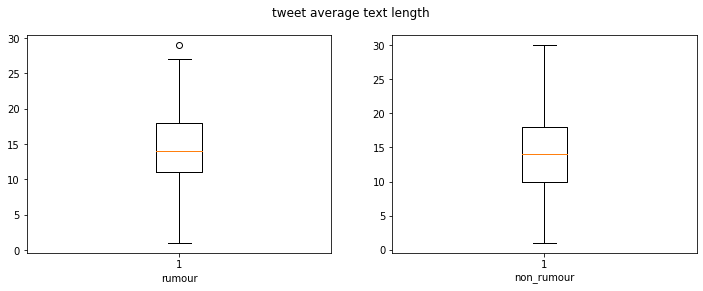

In [24]:
# Average text Length information for rumor and non-rumor, box plot
txt_len_r = final_df.txt_len[final_df.label==1]
txt_len_nr = final_df.txt_len[final_df.label==0]
# Multiple box plots on one Axes
fig, ax = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('tweet average text length')
ax[0].boxplot(txt_len_r)
ax[0].set_xlabel('rumour')
ax[1].boxplot(txt_len_nr)
ax[1].set_xlabel('non_rumour')

Text(0.5, 0, 'non_rumour')

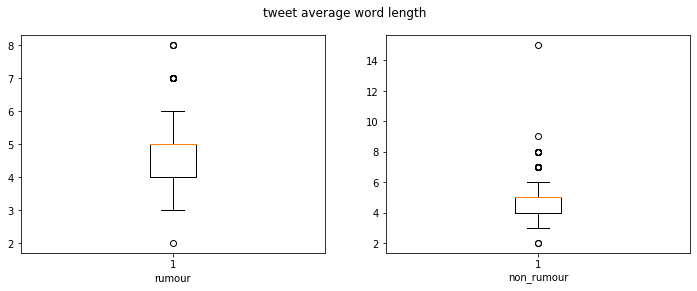

In [25]:
# Average word length information for rumor and non-rumor, box plot
wrd_len_r = final_df.avg_wrd_length[final_df.label==1]
wrd_len_nr = final_df.avg_wrd_length[final_df.label==0]
# Multiple box plots on one Axes
fig, ax = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('tweet average word length')
ax[0].boxplot(wrd_len_r)
ax[0].set_xlabel('rumour')
ax[1].boxplot(wrd_len_nr)
ax[1].set_xlabel('non_rumour')

Text(0.5, 0, 'non_rumour')

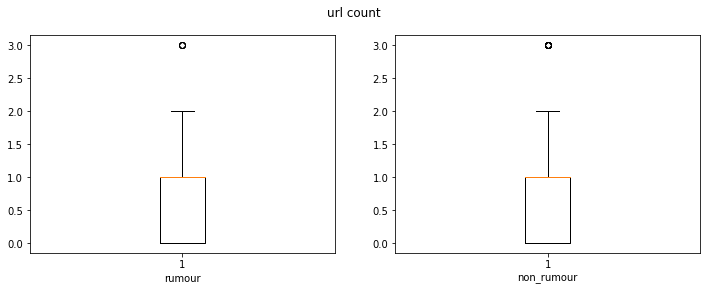

In [26]:
# Punctuation cnt
url_r = final_df.url_cnt[final_df.label==1]
url_nr = final_df.url_cnt[final_df.label==0]
# Multiple box plots on one Axes
fig, ax = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('url count')
ax[0].boxplot(url_r)
ax[0].set_xlabel('rumour')
ax[1].boxplot(url_nr)
ax[1].set_xlabel('non_rumour')

Text(0.5, 0, 'non_rumour')

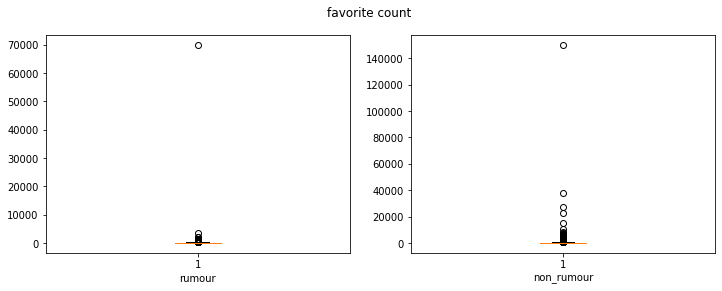

In [27]:
# Punctuation cnt
fav_r = final_df.favorite_count[final_df.label==1]
fav_nr = final_df.favorite_count[final_df.label==0]
# Multiple box plots on one Axes
fig, ax = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('favorite count')
ax[0].boxplot(fav_r)
ax[0].set_xlabel('rumour')
ax[1].boxplot(fav_nr)
ax[1].set_xlabel('non_rumour')